# 4. Bayesian computing

This notebook will cover important [`R`](https://www.r-project.org/) commands highlighted in Ch. 4 of the textbook, *Spatial and Spatio-temporal Bayesian Models with R-INLA* by Blangiardo and Cameletti.

## 4.4. Monte Carlo simulations

### Approximating the average rate parameter

Let's imagine a stochastic process that occurs (i.e., succeeds) at an unknown rate $\lambda$ [1/s]. We collect data by considering $n$ successes and computing the time interval between them (starting from $t=0$). We can simulate this by sampling from the probabilistic model, called the **likelihood** $\rho(\mathcal{D} \vert \theta)$, where we model the wait time interval data as a r.v.

$$
Y \sim \text{Exponential}(\lambda).
$$

Let $\mathbf{y} := (y_i)_{i=1}^n$, where each $y_i$ is an i.i.d. realization of $Y$. Setting $n := 50$ and $\lambda := 2$, we simulate the data using `R`'s [`rexp`](https://stat.ethz.ch/R-manual/R-devel/library/stats/html/Exponential.html) function.

In [5]:
set.seed(1)
n <- 50
lambda <- 2
y <- rexp(n, lambda)
print(y)

 [1] 0.37759092 0.59082139 0.07285336 0.06989763 0.21803431 1.44748427
 [7] 0.61478103 0.26984142 0.47828375 0.07352300 0.69536756 0.38101493
[13] 0.61880178 2.21196711 0.52727158 0.51762197 0.93801759 0.32737332
[19] 0.16846674 0.29423986 1.18225763 0.32094629 0.14706019 0.28293276
[25] 0.05303631 0.02971958 0.28935623 1.97946643 0.58665605 0.49840648
[31] 0.71764267 0.01863426 0.16200508 0.66023396 0.10175518 0.51136294
[37] 0.15087047 0.36260715 0.37577135 0.11751373 0.53994057 0.51412345
[43] 0.64613082 0.62655268 0.27732070 0.15064150 0.64656233 0.49727789
[49] 0.25708715 1.00391620


Our job now is to take the data $\mathbf{y}$ and reverse-engineer the true rate $\lambda$ from it (hopefully we get something close to 2!).

We first need a guess for the rate parameter; in fact, we'll define an entire "guess distribution" for $\lambda$, called the **prior** $\rho(\theta)$, where we assume this nonnegative temporal rate is an instance of a r.v.

$$
\Lambda \sim \text{Gamma}(a,b).
$$

We will set the prior **hyperparameters** $a := 8$ and $b := 4$.

In [6]:
a <- 8
b <- 4

The resulting **posterior** $\rho(\theta \vert \mathcal{D}) \propto \rho(\mathcal{D} \vert \theta)\rho(\theta)$ is **conjugate** to the prior, i.e., the prior-likelihood pair produces a posterior from the same family of distributions as the prior. In this example,

$$
\Lambda \vert \mathbf{Y}=\mathbf{y} \sim \text{Gamma}(a_1,b_1),
$$

where $a_1 := a+n$ and $b_1 := b+n\bar y$ (here $\bar y$ denotes the data mean).

In [7]:
a1 <- a + n
b1 <- b + n*mean(y)

---

#### An aside: Posterior derivation

If it's hard to convince yourself that the resulting posterior distribution, in this case, is indeed another gamma distribution, we will derive this fact here. First we consider the exponential likelihood for *one observation* with its density/**PDF**'s functional form

$$
\rho(y \vert \lambda) = \lambda e^{-\lambda y}.
$$

Similarly, the prior PDF is

$$
\rho(\lambda) \propto \lambda^{a-1}e^{-b\lambda}.
$$

The resulting posterior PDF from the product of the two is, then,

$$
\rho(\lambda \vert y) \propto \lambda^{(a+1)-1}e^{-(b+y)\lambda},
$$

that is, $\Lambda \vert Y=y \sim \text{Gamma}(a+1,b+y)$.

Next, let's consider the case with $n$ observations. Since we assume that they are i.i.d., the likelihood is the product

$$
\rho(\mathbf{y}) = \lambda^n \prod_{i=1}^n e^{-\lambda y_i} = \lambda^n e^{-\lambda \sum_{i=1}^n y_i},
$$

and the resulting posterior is

$$
\rho(\lambda \vert \mathbf{y}) \propto \lambda^{(a+n)-1}e^{-(b+\sum_{i=1}^n y_i)\lambda}.
$$

Noting the equivalence $\sum_{i=1}^n y_i = n\bar y$ from the definition of sample mean, we arrive at the posterior distribution above:

$$
\Lambda \vert \mathbf{Y}=\mathbf{y} \sim \text{Gamma}(a+n,b+n\bar y).
$$

---

Given this posterior, we can now answer the question of, "What is the rate parameter given the data (and prior assumptions)?". One such answer is to take the expected value of the posterior distribution, that is, $\hat\lambda := \mathbb{E}[\Lambda \vert \mathbf{Y}=\mathbf{y}]$. In this particular case, there is an analytical form of $\hat\lambda$, namely, $\frac{a_1}{b_1} = \frac{a+n}{b+n\bar y}$.

In [12]:
lambdahat <- a1/b1
print(mu)

[1] 2.027898


However, an alternate answer to our question could have been the median of the posterior. Even in the case with a well-known (gamma) distribution, there is no analytical form for the median and it must be approximated asymptotically/computationally. We can even anticipate more difficult cases where not even an asymptotic form exists; how, then, should we go around this problem? One answer is with **Monte Carlo simulations**.

Let's continue with the expected value example. We want to simulate samples of $\lambda$ from the posterior gamma distribution. We will set the number of samples as $m := 1000$ and use `R`'s [`rgamma`](https://stat.ethz.ch/R-manual/R-devel/library/stats/html/GammaDist.html) function. Finally, we take the sample mean to get the simulated estimate $\bar\lambda$.

In [13]:
set.seed(2)
m <- 1000
lambdas <- rgamma(m, a1, rate=b1)
lambdabar <- mean(lambdas)
print(lambdabar)

[1] 2.040972


The sample mean $\bar\lambda \approx 2.040972$ is not too far off from the theoretical mean $\hat\lambda \approx 2.027898$, which is not a bad estimate of the unknown, data-generating rate $\lambda = 2$.

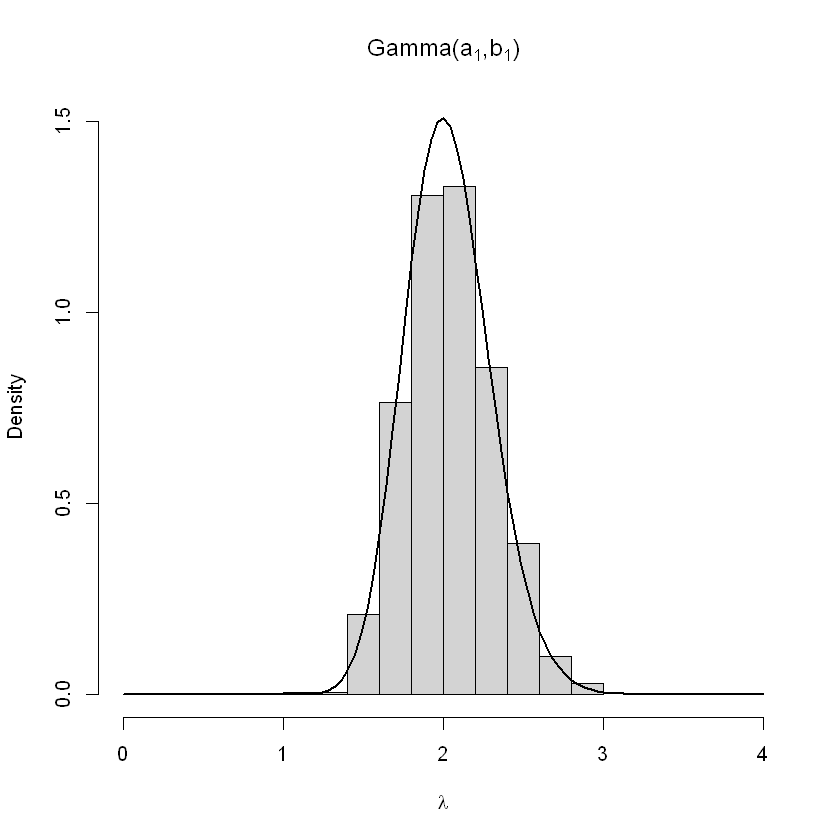

In [10]:
hist(lambdas, freq=F, xlim=c(0,4), ylim=c(0,1.5), xlab=expression(lambda),
     main=expression(paste("Gamma(", a[1], ",", b[1], ")")))
curve(dgamma(x, a1, rate=b1), from=0, to=4, lwd=2, add=T)